3. [Testing data sampling scheme](#Testing-data-sampling-scheme)

# Testing data sampling scheme

In [1]:
import sys
print (sys.version)

2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline

RERUN_KW_SAMPLE_TEST=False
RERUN_JAL_SAMPLE_TEST=True
RERUN_SK_SAMPLE_TEST=False

In [3]:
behav_data_f = 'Phenotypic_V1_0b_preprocessed1.csv'

In [4]:
df = pd.read_csv(behav_data_f)
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])
df.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,AGE_YRS
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,24.0
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,19.0
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0,13.0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1,13.0
5,5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,...,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1,17.0


In [5]:
motion_thresh = 10

In [6]:
# Start by removing all participants whose data is below a certain
# motion threshold.
df_samp_motion = df.loc[df['func_perc_fd'] < motion_thresh, :]
df_samp_motion.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,AGE_YRS
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1,13.0
7,7,8,50009,8,50009,PITT,Pitt_0050009,1,1,33.86,...,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,OK,NaN,1,33.0
8,8,9,50010,9,50010,PITT,Pitt_0050010,1,1,35.20,...,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1,35.0
9,9,10,50011,10,50011,PITT,Pitt_0050011,1,1,16.93,...,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,0,16.0
10,10,11,50012,11,50012,PITT,Pitt_0050012,1,1,21.48,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,21.0


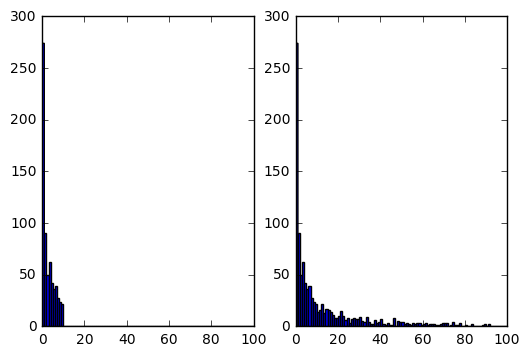

In [7]:
plt.figure(1)
plt.subplot(121)
plt.hist(df_samp_motion.func_perc_fd, range=(0,100), bins=100)
plt.subplot(122)
blah = plt.hist(df.func_perc_fd, range=(0,100), bins=100)

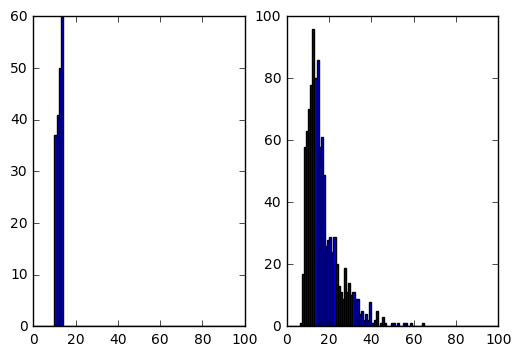

In [8]:
age_l=10
age_u=age_l+3
# Then remove participants who are younger (in years) than age_l and older
# than age_u. Note that this means people who are age_l and age_u
# (eg 6 and 10) will be included in the sample.
df_samp = df_samp_motion.loc[(df_samp_motion['AGE_YRS']>=age_l)
                                & (df_samp_motion['AGE_YRS']<=age_u), :]
plt.figure(1)
plt.subplot(121)
plt.hist(df_samp.AGE_YRS, range=(0,100), bins=100)
plt.subplot(122)
blah = plt.hist(df.AGE_YRS, range=(0,100), bins=100)

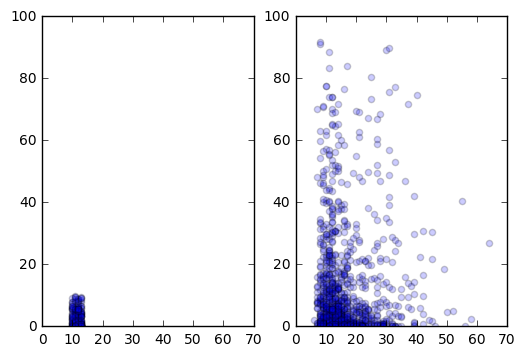

In [9]:
plt.figure(1)
plt.subplot(121)
plt.scatter(df_samp.AGE_YRS, df_samp.func_perc_fd, alpha=.2)
plt.ylim(0, 100)
plt.xlim(0, 70)
plt.subplot(122)
plt.ylim(0, 100)
plt.xlim(0, 70)
blah = plt.scatter(df.AGE_YRS, df.func_perc_fd, alpha=.2)

In [10]:
n=30
# Shuffle these remaining participants to ensure you get different sub
# samples each time you run the code.
df_samp_rand = df_samp.reindex(np.random.permutation(df_samp.index))

# Only keep the top 2*n participants.
df_samp_2n = df_samp_rand.iloc[:2*n, :]

# Sort these participants according to the sort columns of interest
sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
df_samp_2n_sorted = df_samp_2n.sort_values(by=sort_column_list)

# Now put all even numbered participants in group A and all odd numbered
# participants in group B.
df_grp_A = df_samp_2n_sorted.iloc[::2, :]
df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

In [11]:
(df_grp_A.subject.shape,
df_grp_B.subject.shape)

((30,), (30,))

In [12]:
n=150
# Shuffle these remaining participants to ensure you get different sub
# samples each time you run the code.
df_samp_rand = df_samp.reindex(np.random.permutation(df_samp.index))

# Only keep the top 2*n participants.
df_samp_2n = df_samp_rand.iloc[:2*n, :]

# Sort these participants according to the sort columns of interest
sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
df_samp_2n_sorted = df_samp_2n.sort_values(by=sort_column_list)

# Now put all even numbered participants in group A and all odd numbered
# participants in group B.
df_grp_A = df_samp_2n_sorted.iloc[::2, :]
df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

In [13]:
(df_grp_A.subject.shape[0],
df_grp_B.subject.shape[0])

(94, 94)

It appears that, at least in this slice (age 10-13, < 10% bad volumes), we only have a maximum of 94\*2=188 subjects to work with, and so every iteration with these cutoffs, we're just remixing this subsample. As we increase our motion cuttoff, or rather reduce its stringency, we increase our available sampling pool

In [339]:
def split_two_matched_samples(df, motion_thresh, age_l, age_u, n):
    """
    This function takes in a data frame, thresholds it to only include
    participants whose percentage bad frames are less than motion_thresh
    and participants who are between the lower and upper age limits (inclusive),
    then returns two matched samples of size n. The samples are matched on
    age in years, autism diagnosis, gender and scanning site.
    Information about the motion measure is here:
    http://preprocessed-connectomes-project.org/quality-assessment-protocol/
    """

    # Start by removing all participants whose data is below a certain
    # motion threshold.
    df_samp_motion = df.loc[df['func_perc_fd'] < motion_thresh, :]

    # Then remove participants who are younger (in years) than age_l and older
    # than age_u. Note that this means people who are age_l and age_u
    # (eg 6 and 10) will be included in the sample.
    df_samp = df_samp_motion.loc[(df_samp_motion['AGE_YRS']>=age_l)
                                    & (df_samp_motion['AGE_YRS']<=age_u), :]

    # Shuffle these remaining participants to ensure you get different sub
    # samples each time you run the code.
    df_samp_rand = df_samp.reindex(np.random.permutation(df_samp.index))

    # Only keep the top 2*n participants.
    df_samp_2n = df_samp_rand.iloc[:2*n, :]

    # Sort these participants according to the sort columns of interest
    sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
    df_samp_2n_sorted = df_samp_2n.sort_values(by=sort_column_list)

    # Now put all even numbered participants in group A and all odd numbered
    # participants in group B.
    df_grp_A = df_samp_2n_sorted.iloc[::2, :]
    df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

    # Boom! Return these two data frames
    return df_grp_A, df_grp_B
def split_two_matched_samples_JAL(df, motion_thresh, age_l, age_u, n):
    """
    This function takes in a data frame, thresholds it to only include
    participants whose percentage bad frames are less than motion_thresh
    and participants who are between the lower and upper age limits (inclusive),
    then returns two matched samples of size n. The samples are matched on
    age in years, autism diagnosis, gender and scanning site. This function also selectively samples the
    func_perc_fd
    Information about the motion measure is here:
    http://preprocessed-connectomes-project.org/quality-assessment-protocol/
    """
    
    # Start by removing all participants whose data is below a certain
    # motion threshold.
    df_samp_motion =  df.loc[df['func_perc_fd'] < motion_thresh, :]

    # Then remove participants who are younger (in years) than age_l and older
    # than age_u. Note that this means people who are age_l and age_u
    # (eg 6 and 10) will be included in the sample.
    df_samp = df_samp_motion.loc[(df_samp_motion['AGE_YRS']>=age_l)
                                    & (df_samp_motion['AGE_YRS']<=age_u), :]
                                    
    ##sort subjects based on motion
    sort_column_list = ['func_perc_fd']
    df_motion_sorted = df_samp.sort_values(by=sort_column_list)
    
    ##rank subjects by motion
    r=range(len(df_motion_sorted))
    r_df=pd.DataFrame(r)
    r_df.columns = ['rank']
    r_df['newcol'] = df_motion_sorted.index
    r_df.set_index('newcol', inplace=True)
    r_df.index.names = [None]
    df_motion_sorted_rank=pd.concat ([r_df,df_motion_sorted], axis=1)
    
    ##create bins of subjects in quartiles
    l=len(df_motion_sorted_rank)
    chunk=l/4
    chunk1=chunk
    chunk2=2*chunk
    chunk3=3*chunk
    chunk4=l
    
    first=df_motion_sorted_rank[df_motion_sorted_rank['rank']<=chunk1]
    second=df_motion_sorted_rank[(df_motion_sorted_rank['rank']>chunk1) & (df_motion_sorted_rank['rank']<=chunk2)]
    third=df_motion_sorted_rank[(df_motion_sorted_rank['rank']>chunk2) & (df_motion_sorted_rank['rank']<=chunk3)]
    fourth=df_motion_sorted_rank[df_motion_sorted_rank['rank']>=chunk3]
    
    ##take 2n/4 from each bin
    n_samp=(n*2)/4
    n_samp

    # Shuffle these remaining participants to ensure you get different sub
    # samples each time you run the code.
    first_rand = first.reindex(np.random.permutation(first.index))
    second_rand = second.reindex(np.random.permutation(second.index))
    third_rand = third.reindex(np.random.permutation(third.index))
    fourth_rand = fourth.reindex(np.random.permutation(fourth.index))
    first_rand['bin_number'] = 1
    second_rand['bin_number'] = 2
    third_rand['bin_number'] = 3
    fourth_rand['bin_number'] = 4

    # Only keep the top 2*n/4 participants.
    first_samp_2n = first_rand.iloc[:n_samp, :]
    second_samp_2n = second_rand.iloc[:n_samp, :]
    third_samp_2n = third_rand.iloc[:n_samp, :]
    fourth_samp_2n = fourth_rand.iloc[:n_samp, :]
    
    #append these together
    frames = [first_samp_2n, second_samp_2n, third_samp_2n,fourth_samp_2n]
    final_df = pd.concat(frames)

    # Sort these participants according to the sort columns of interest
    sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
    df_samp_2n_sorted = final_df.sort_values(by=sort_column_list)

    # Now put all even numbered participants in group A and all odd numbered
    # participants in group B.
    df_grp_A = df_samp_2n_sorted.iloc[::2, :]
    df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

    # Boom! Return these two data frames
    return df_grp_A, df_grp_B

Let's look at how often a particular subject ID re-occurs at different sample sizes.

In [268]:
if (RERUN_KW_SAMPLE_TEST==True):
    age_l = 6; age_u = 18
    n_perms = 500

    proportionDF = pd.DataFrame()

    for motion_thresh in range(5, 55, 5):
        for n in range(30, 330, 30):
            subs = None
            DX_GROUP_prop_diff = []
            SEX_prop_diff = []
            AGE_YRS_prop_diff = []
            for i in range(n_perms):
                #create two matched samples split on motion_thresh, age upper, age lower, and n
                df_A, df_B = split_two_matched_samples(df, motion_thresh, age_l, age_u, n)
                subs = pd.concat([subs, df_A.loc[:, 'subject'], df_B.loc[:, 'subject']])
                DX_GROUP_prop_diff = np.append(DX_GROUP_prop_diff, 
                                               df_A[df_A['DX_GROUP']==1].count()/df_A.shape[0]-
                                               df_B[df_B['DX_GROUP']==1].count()/df_B.shape[0])
                SEX_prop_diff = np.append(SEX_prop_diff, 
                                          df_A[df_A['SEX']==1].count()/df_A.shape[0]-
                                          df_B[df_B['SEX']==1].count()/df_B.shape[0])
                AGE_YRS_prop_diff = np.append(AGE_YRS_prop_diff, 
                                              pd.DataFrame(df_A['AGE_YRS'].value_counts()/df_A.shape[0])-
                                              pd.DataFrame(df_B['AGE_YRS'].value_counts()/df_B.shape[0]))
            proportionDF = proportionDF.append(
                {'motion_thresh' : motion_thresh, 
                 'N_set' : n*2,
                 'N_obs' : subs.shape[0]/n_perms,
                 'prop_min' : float(subs.value_counts().min())/n_perms,
                 'prop_max' : float(subs.value_counts().max())/n_perms,
                 'dx_prop_diff_min' : DX_GROUP_prop_diff.min(),
                 'dx_prop_diff_max' : DX_GROUP_prop_diff.max(),
                 'sex_prop_diff_min' : SEX_prop_diff.min(),
                 'sex_prop_diff_max' : SEX_prop_diff.max(),
                 'age_props_diff_min' : np.nanmin(AGE_YRS_prop_diff),
                 'age_props_diff_max' : np.nanmax(AGE_YRS_prop_diff)},
                ignore_index=True)
    proportionDF.to_json(path_or_buf='test_of_proportions_KW.json')
else:
    proportionDF = pd.read_json(path_or_buf='test_of_proportions_KW.json')

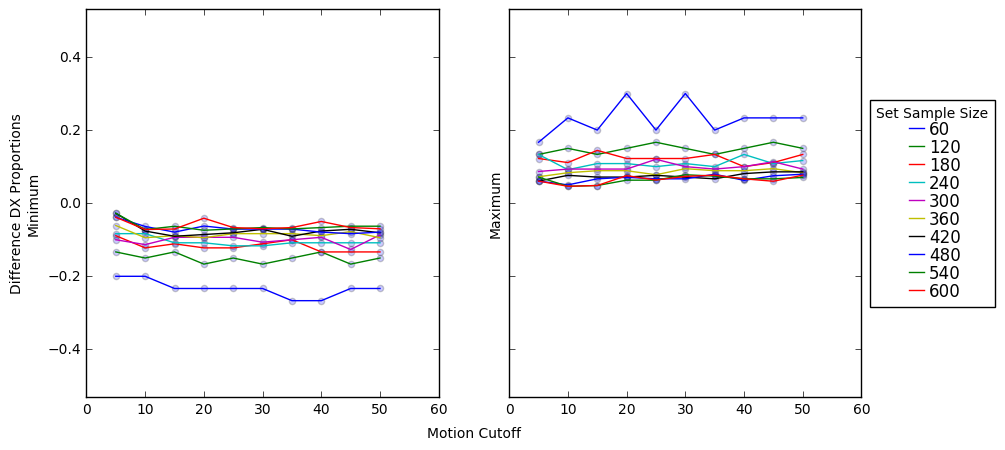

In [284]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF.query("N_set == " + str(N_set))
    propPlotAx[0].scatter(tmpPropDF.motion_thresh, tmpPropDF.dx_prop_diff_min, alpha=.2)
    propPlotAx[0].plot(tmpPropDF.motion_thresh, tmpPropDF.dx_prop_diff_min)
    propPlotAx[1].scatter(tmpPropDF.motion_thresh, tmpPropDF.dx_prop_diff_max, alpha=.2)
    propPlotAx[1].plot(tmpPropDF.motion_thresh, tmpPropDF.dx_prop_diff_max)
    labels.append(N_set)

handles, labels_trash = propPlotAx[1].get_legend_handles_labels()
propPlotAx[0].set_ylim([-.53, .53])
propPlotAx[0].set_xlabel('Motion Cutoff')
propPlotAx[0].xaxis.set_label_coords(1.1, -.075)
propPlotAx[0].set_ylabel('Difference DX Proportions\nMinimum')
propPlotAx[1].set_ylabel('\nMaximum')
propPlotAx[1].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

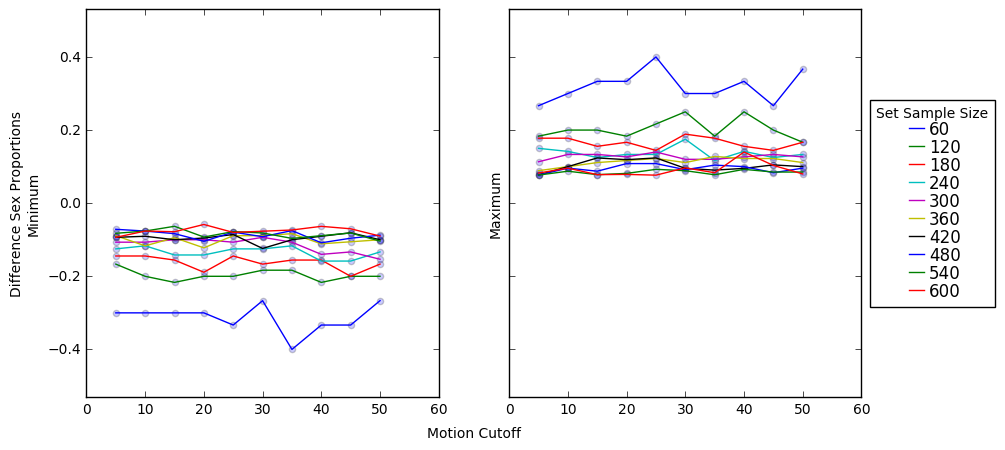

In [285]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF.query("N_set == " + str(N_set))
    propPlotAx[0].scatter(tmpPropDF.motion_thresh, tmpPropDF.sex_prop_diff_min, alpha=.2)
    propPlotAx[0].plot(tmpPropDF.motion_thresh, tmpPropDF.sex_prop_diff_min)
    propPlotAx[1].scatter(tmpPropDF.motion_thresh, tmpPropDF.sex_prop_diff_max, alpha=.2)
    propPlotAx[1].plot(tmpPropDF.motion_thresh, tmpPropDF.sex_prop_diff_max)
    labels.append(N_set)

handles, labels_trash = propPlotAx[1].get_legend_handles_labels()
propPlotAx[0].set_ylim([-.53, .53])
propPlotAx[0].set_xlabel('Motion Cutoff')
propPlotAx[0].xaxis.set_label_coords(1.1, -.075)
propPlotAx[0].set_ylabel('Difference Sex Proportions\nMinimum')
propPlotAx[1].set_ylabel('\nMaximum')
propPlotAx[1].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

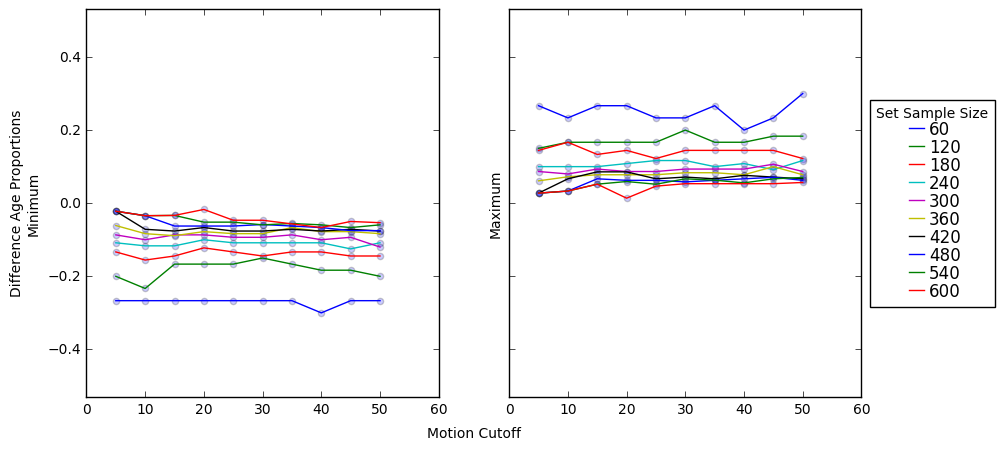

In [286]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF.query("N_set == " + str(N_set))
    propPlotAx[0].scatter(tmpPropDF.motion_thresh, tmpPropDF.age_props_diff_min, alpha=.2)
    propPlotAx[0].plot(tmpPropDF.motion_thresh, tmpPropDF.age_props_diff_min)
    propPlotAx[1].scatter(tmpPropDF.motion_thresh, tmpPropDF.age_props_diff_max, alpha=.2)
    propPlotAx[1].plot(tmpPropDF.motion_thresh, tmpPropDF.age_props_diff_max)
    labels.append(N_set)

handles, labels_trash = propPlotAx[1].get_legend_handles_labels()
propPlotAx[0].set_ylim([-.53, .53])
propPlotAx[0].set_xlabel('Motion Cutoff')
propPlotAx[0].xaxis.set_label_coords(1.1, -.075)
propPlotAx[0].set_ylabel('Difference Age Proportions\nMinimum')
propPlotAx[1].set_ylabel('\nMaximum')
propPlotAx[1].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

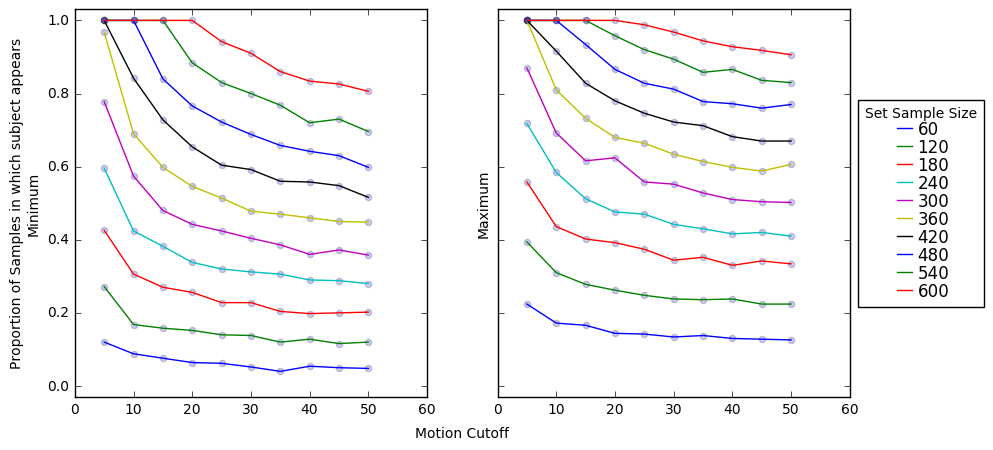

In [287]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF.query("N_set == " + str(N_set))
    propPlotAx[0].scatter(tmpPropDF.motion_thresh, tmpPropDF.prop_min, alpha=.2)
    propPlotAx[0].plot(tmpPropDF.motion_thresh, tmpPropDF.prop_min)
    propPlotAx[1].scatter(tmpPropDF.motion_thresh, tmpPropDF.prop_max, alpha=.2)
    propPlotAx[1].plot(tmpPropDF.motion_thresh, tmpPropDF.prop_max)
    labels.append(N_set)

handles, labels_trash = propPlotAx[1].get_legend_handles_labels()
propPlotAx[0].set_ylim([-.03, 1.03])
propPlotAx[0].set_xlabel('Motion Cutoff')
propPlotAx[0].xaxis.set_label_coords(1.1, -.075)
propPlotAx[0].set_ylabel('Proportion of Samples in which subject appears\nMinimum')
propPlotAx[1].set_ylabel('\nMaximum')
propPlotAx[1].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

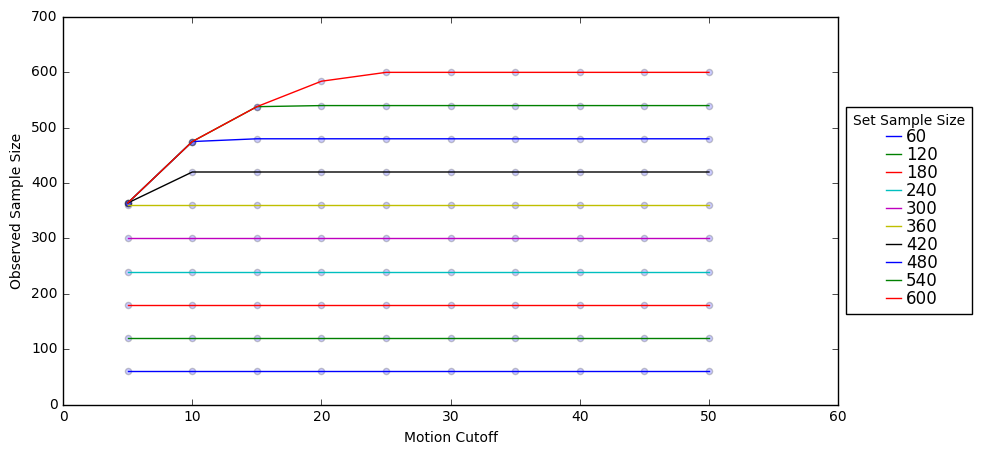

In [288]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF.query("N_set == " + str(N_set))
    propPlotAx.scatter(tmpPropDF.motion_thresh, tmpPropDF.N_obs, alpha=.2)
    propPlotAx.plot(tmpPropDF.motion_thresh, tmpPropDF.N_obs)
    labels.append(N_set)

handles, labels_trash = propPlotAx.get_legend_handles_labels()
propPlotAx.set_xlabel('Motion Cutoff')
propPlotAx.set_ylabel('Observed Sample Size')
propPlotAx.legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

## Conclusion

We're not actually able to iterate over sample size very well. Also, at low motion cutoffs, and high sample sizes, we're merely shuffling groups in each iteration. This might be helped by looking at a single, wide age range (the above is just ages 10-13), or bootstrap sampling with replacement.

# Testing scikit-learn

In [54]:
import sklearn.cross_validation as skcv

In [55]:
behav_data_f = '../../Phenotypic_V1_0b_preprocessed1.csv'

In [56]:
df = pd.read_csv(behav_data_f)
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])
df = df.query('AGE_YRS >= 6 & AGE_YRS <= 18 & (DX_GROUP == 1 | DX_GROUP ==2) ')
df.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,AGE_YRS
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0,13.0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1,13.0
5,5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,...,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1,17.0
9,9,10,50011,10,50011,PITT,Pitt_0050011,1,1,16.93,...,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,0,16.0
11,11,12,50013,12,50013,PITT,Pitt_0050013,1,1,9.33,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,9.0


In [124]:
strata = df.groupby(['DX_GROUP', 'SEX']).grouper.group_info[0]
strata.shape

(743,)

We actually can't stratify on all the original columns &mdash; `['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']` &mdash; because there is sometimes only a single case in that stratum. Instead, I'll just stratify on `DX_GROUP` and `SEX`.

In [244]:
blah=np.array([float('NaN'), 1, 2, 3])
np.nanmin(blah)

1.0

In [290]:
if (RERUN_SK_SAMPLE_TEST==True):
    motion_thresh = 10;
    n_perms = 500

    proportionDF_skcv = pd.DataFrame()
    df_age_thres = df.query('AGE_YRS >= 6 & AGE_YRS <= 18')

    for motion_thresh in range(5, 55, 5):
        df_threshed = df_age_thres.loc[df['func_perc_fd'] < motion_thresh, :]
        strata = df_threshed.groupby(['DX_GROUP', 'SEX']).grouper.group_info[0]
        for n in range(30, 330, 30):
            #print("%s %s" % (n*2, strata.shape[0]))
            if n*2 > strata.shape[0]:
                proportionDF_skcv = proportionDF_skcv.append(
                    {'motion_thresh' : motion_thresh, 
                     'N_set' : n*2,
                     'N_obs' : strata.shape[0],
                     'prop_min' : 1,
                     'prop_max' : 1},
                    ignore_index=True)
            else:
                subs = None
                DX_GROUP_prop_diff = []
                SEX_prop_diff = []
                AGE_YRS_prop_diff = []
                asplit = skcv.StratifiedShuffleSplit(y=strata, n_iter=n_perms, test_size=n, train_size=n)
                for train_index, test_index in asplit:
                    df_A, df_B = df_threshed.loc[train_index, :], df_threshed.loc[test_index, :]
                    subs = pd.concat([subs, df_A.loc[:, 'subject'], df_B.loc[:, 'subject']])
                    DX_GROUP_prop_diff = np.append(DX_GROUP_prop_diff, 
                                                   df_A[df_A['DX_GROUP']==1].count()/df_A.shape[0]-
                                                   df_B[df_B['DX_GROUP']==1].count()/df_B.shape[0])
                    SEX_prop_diff = np.append(SEX_prop_diff, 
                                              df_A[df_A['SEX']==1].count()/df_A.shape[0]-
                                              df_B[df_B['SEX']==1].count()/df_B.shape[0])
                    AGE_YRS_prop_diff = np.append(AGE_YRS_prop_diff, 
                                                  pd.DataFrame(df_A['AGE_YRS'].value_counts()/df_A.shape[0])-
                                                  pd.DataFrame(df_B['AGE_YRS'].value_counts()/df_B.shape[0]))
                proportionDF_skcv = proportionDF_skcv.append(
                    {'motion_thresh' : motion_thresh, 
                     'N_set' : n*2,
                     'N_obs' : subs.shape[0]/n_perms,
                     'prop_min' : float(subs.value_counts().min())/n_perms,
                     'prop_max' : float(subs.value_counts().max())/n_perms,
                     'dx_prop_diff_min' : DX_GROUP_prop_diff.min(),
                     'dx_prop_diff_max' : DX_GROUP_prop_diff.max(),
                     'sex_prop_diff_min' : SEX_prop_diff.min(),
                     'sex_prop_diff_max' : SEX_prop_diff.max(),
                     'age_props_diff_min' : np.nanmin(AGE_YRS_prop_diff),
                     'age_props_diff_max' : np.nanmax(AGE_YRS_prop_diff)},
                    ignore_index=True)
    proportionDF_skcv.to_json(path_or_buf='test_of_proportions_SK.json')
else:
    proportionDF_skcv = pd.read_json(path_or_buf='test_of_proportions_SK.json')
        
proportionDF_skcv.head()

,N_obs,N_set,age_props_diff_max,age_props_diff_min,dx_prop_diff_max,dx_prop_diff_min,motion_thresh,prop_max,prop_min,sex_prop_diff_max,sex_prop_diff_min
0,60.0,60.0,0.200000,-0.200000,0.333333,-0.433333,5.0,0.220,0.102,0.333333,-0.366667
1,120.0,120.0,0.133333,-0.133333,0.216667,-0.200000,5.0,0.402,0.270,0.250000,-0.283333
2,180.0,180.0,0.111111,-0.133333,0.177778,-0.177778,5.0,0.554,0.432,0.233333,-0.211111
3,240.0,240.0,0.100000,-0.100000,0.158333,-0.183333,5.0,0.744,0.594,0.225000,-0.175000
4,300.0,300.0,0.086667,-0.086667,0.173333,-0.146667,5.0,0.868,0.768,0.166667,-0.186667


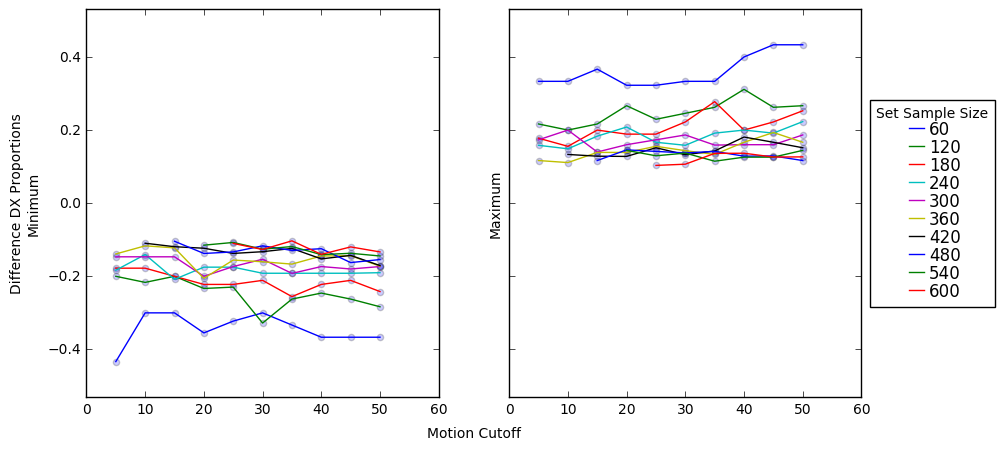

In [292]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF_skcv.query("N_set == " + str(N_set))
    propPlotAx[0].scatter(tmpPropDF.motion_thresh, tmpPropDF.dx_prop_diff_min, alpha=.2)
    propPlotAx[0].plot(tmpPropDF.motion_thresh, tmpPropDF.dx_prop_diff_min)
    propPlotAx[1].scatter(tmpPropDF.motion_thresh, tmpPropDF.dx_prop_diff_max, alpha=.2)
    propPlotAx[1].plot(tmpPropDF.motion_thresh, tmpPropDF.dx_prop_diff_max)
    labels.append(N_set)

handles, labels_trash = propPlotAx[1].get_legend_handles_labels()
propPlotAx[0].set_ylim([-.53, .53])
propPlotAx[0].set_xlabel('Motion Cutoff')
propPlotAx[0].xaxis.set_label_coords(1.1, -.075)
propPlotAx[0].set_ylabel('Difference DX Proportions\nMinimum')
propPlotAx[1].set_ylabel('\nMaximum')
propPlotAx[1].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

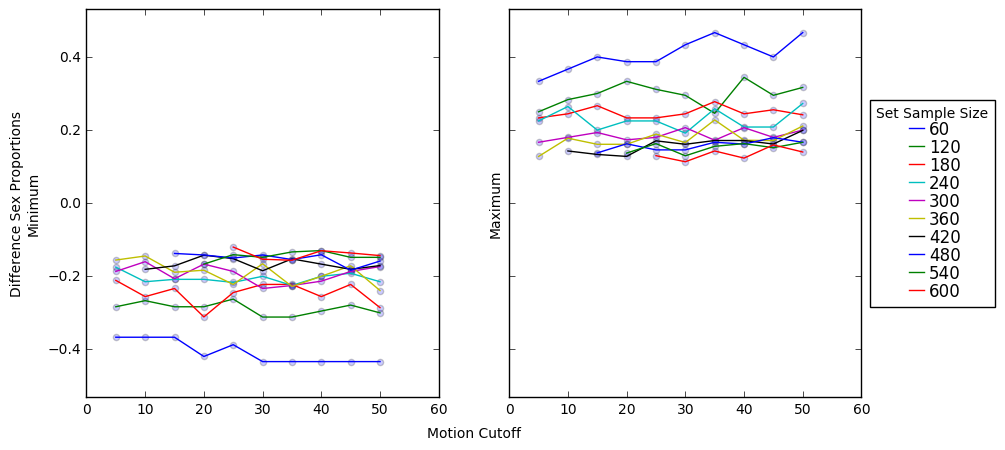

In [293]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF_skcv.query("N_set == " + str(N_set))
    propPlotAx[0].scatter(tmpPropDF.motion_thresh, tmpPropDF.sex_prop_diff_min, alpha=.2)
    propPlotAx[0].plot(tmpPropDF.motion_thresh, tmpPropDF.sex_prop_diff_min)
    propPlotAx[1].scatter(tmpPropDF.motion_thresh, tmpPropDF.sex_prop_diff_max, alpha=.2)
    propPlotAx[1].plot(tmpPropDF.motion_thresh, tmpPropDF.sex_prop_diff_max)
    labels.append(N_set)

handles, labels_trash = propPlotAx[1].get_legend_handles_labels()
propPlotAx[0].set_ylim([-.53, .53])
propPlotAx[0].set_xlabel('Motion Cutoff')
propPlotAx[0].xaxis.set_label_coords(1.1, -.075)
propPlotAx[0].set_ylabel('Difference Sex Proportions\nMinimum')
propPlotAx[1].set_ylabel('\nMaximum')
propPlotAx[1].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

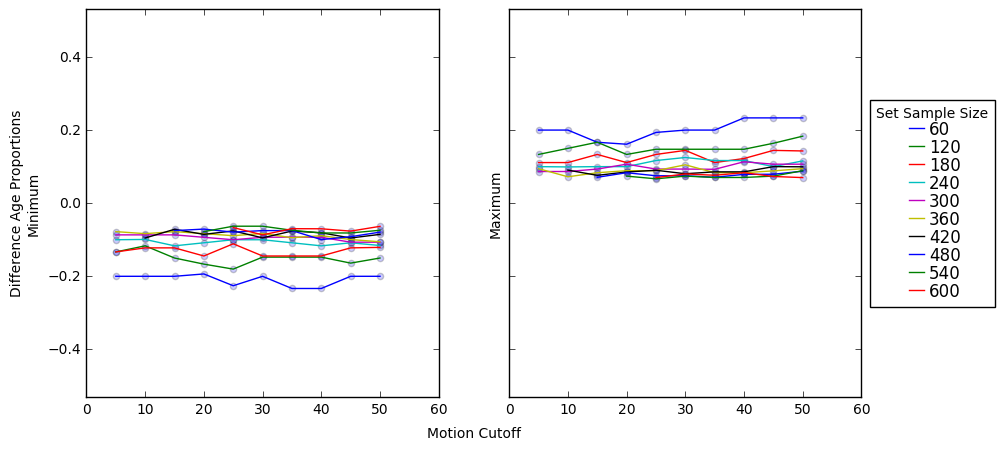

In [294]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF_skcv.query("N_set == " + str(N_set))
    propPlotAx[0].scatter(tmpPropDF.motion_thresh, tmpPropDF.age_props_diff_min, alpha=.2)
    propPlotAx[0].plot(tmpPropDF.motion_thresh, tmpPropDF.age_props_diff_min)
    propPlotAx[1].scatter(tmpPropDF.motion_thresh, tmpPropDF.age_props_diff_max, alpha=.2)
    propPlotAx[1].plot(tmpPropDF.motion_thresh, tmpPropDF.age_props_diff_max)
    labels.append(N_set)

handles, labels_trash = propPlotAx[1].get_legend_handles_labels()
propPlotAx[0].set_ylim([-.53, .53])
propPlotAx[0].set_xlabel('Motion Cutoff')
propPlotAx[0].xaxis.set_label_coords(1.1, -.075)
propPlotAx[0].set_ylabel('Difference Age Proportions\nMinimum')
propPlotAx[1].set_ylabel('\nMaximum')
propPlotAx[1].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

Looks like proportion differences are more variable with smaller sample sizes, but no other systematic relationship. That's good.

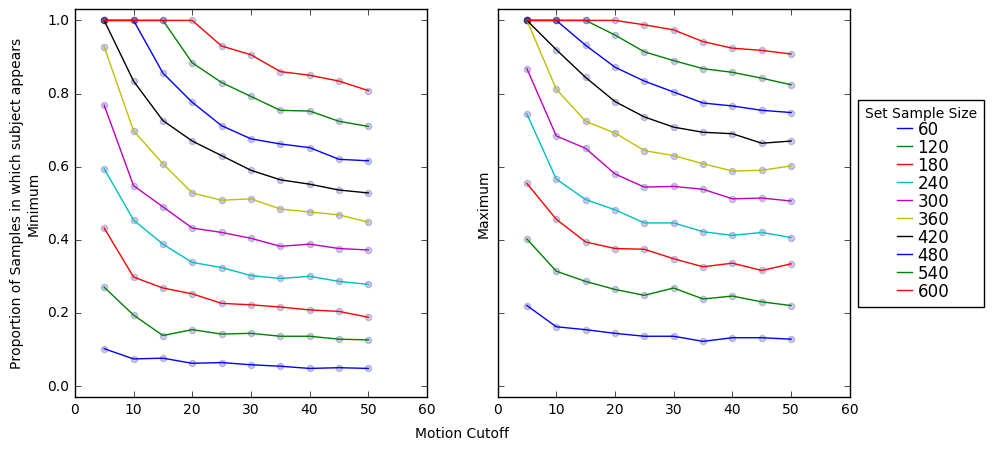

In [295]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF_skcv.query("N_set == " + str(N_set))
    propPlotAx[0].scatter(tmpPropDF.motion_thresh, tmpPropDF.prop_min, alpha=.2)
    propPlotAx[0].plot(tmpPropDF.motion_thresh, tmpPropDF.prop_min)
    propPlotAx[1].scatter(tmpPropDF.motion_thresh, tmpPropDF.prop_max, alpha=.2)
    propPlotAx[1].plot(tmpPropDF.motion_thresh, tmpPropDF.prop_max)
    labels.append(N_set)

handles, labels_trash = propPlotAx[1].get_legend_handles_labels()
propPlotAx[0].set_ylim([-.03, 1.03])
propPlotAx[0].set_xlabel('Motion Cutoff')
propPlotAx[0].xaxis.set_label_coords(1.1, -.075)
propPlotAx[0].set_ylabel('Proportion of Samples in which subject appears\nMinimum')
propPlotAx[1].set_ylabel('\nMaximum')
propPlotAx[1].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

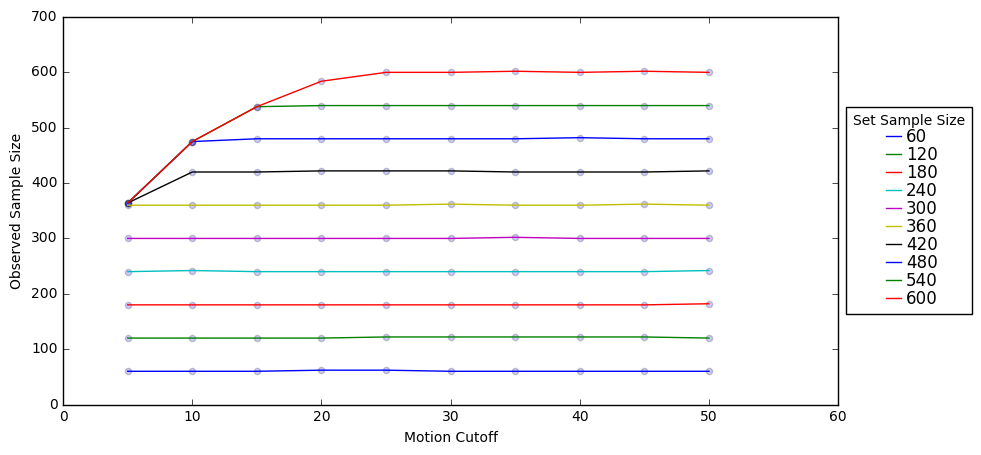

In [296]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF_skcv.query("N_set == " + str(N_set))
    propPlotAx.scatter(tmpPropDF.motion_thresh, tmpPropDF.N_obs, alpha=.2)
    propPlotAx.plot(tmpPropDF.motion_thresh, tmpPropDF.N_obs)
    labels.append(N_set)

handles, labels_trash = propPlotAx.get_legend_handles_labels()
propPlotAx.set_xlabel('Motion Cutoff')
propPlotAx.set_ylabel('Observed Sample Size')
propPlotAx.legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

## Conclusion

Basically, we have the same problem, because the shuffle is being done the same way.

## Testing JAL's new function

We actually need to test this function on a different range of parameters, because she's assuming that sample size per set is 100.

In [553]:
if (RERUN_JAL_SAMPLE_TEST==True):
    def proportion_equal_to(acol, value):
            a_length = len(acol)
            num_equal_to = len(acol[acol == value])
            prop = num_equal_to/float(a_length)
            return prop
    
    age_l = 6; age_u = 18
    n_perms = 500

    proportionDF_JAL = pd.DataFrame()

    for motion_thresh in range(5, 55, 5):
        for n in range(30, 110, 10):
            subs = None
            DX_GROUP_prop_diff = pd.DataFrame()
            SEX_prop_diff = pd.DataFrame()
            AGE_YRS_mean_diff = pd.DataFrame()
            for i in range(n_perms):
                #create two matched samples split on motion_thresh, age upper, age lower, and n
                df_A, df_B = split_two_matched_samples_JAL(df, motion_thresh, age_l, age_u, n)
                subs = pd.concat([subs, df_A.loc[:, 'subject'], df_B.loc[:, 'subject']])
                
                DX_GROUP_prop_diff = pd.concat([DX_GROUP_prop_diff, 
                                               pd.DataFrame(np.abs(
                                df_A.groupby('bin_number').agg({'DX_GROUP' : lambda x: proportion_equal_to(x, 1)})-
                                df_B.groupby('bin_number').agg({'DX_GROUP' : lambda x: proportion_equal_to(x, 1)})))])
                SEX_prop_diff = pd.concat([SEX_prop_diff, 
                                               pd.DataFrame(np.abs(
                                df_A.groupby('bin_number').agg({'SEX' : lambda x: proportion_equal_to(x, 1)})-
                                df_B.groupby('bin_number').agg({'SEX' : lambda x: proportion_equal_to(x, 1)})))])
                AGE_YRS_mean_diff = pd.concat([AGE_YRS_mean_diff, 
                                               pd.DataFrame(np.abs(
                                df_A.groupby('bin_number').agg({'AGE_YRS' : 'mean'})-
                                df_B.groupby('bin_number').agg({'AGE_YRS' : 'mean'})))])
            thisDF = pd.concat([DX_GROUP_prop_diff.groupby(DX_GROUP_prop_diff.index).agg(['mean', 'min', 'max']),
                                SEX_prop_diff.groupby(DX_GROUP_prop_diff.index).agg(['mean', 'min', 'max']),
                                AGE_YRS_mean_diff.groupby(DX_GROUP_prop_diff.index).agg(['mean', 'min', 'max'])],
                               axis=1)
            thisDF = thisDF.unstack().reset_index()
            thisDF['motion_thresh'] = motion_thresh
            thisDF['N_set'] = n
            thisDF['n_perms'] = n_perms
            proportionDF_JAL = pd.concat([proportionDF_JAL,
                                          thisDF],
                                         axis=0)
    proportionDF_JAL.columns = ['property', 'statistic', 'bin_number', 'value'] + list(proportionDF_JAL.columns[range(4,7)])
    proportionDF_JAL.reset_index(inplace=True, drop=True)
    proportionDF_JAL.to_json(path_or_buf='test_of_proportions_JAL.json')   
else:
    proportionDF_JAL = pd.read_json(path_or_buf='test_of_proportions_JAL.json')

In [554]:
list(enumerate(np.array(['a','b','c'])))

[(0, 'a'), (1, 'b'), (2, 'c')]

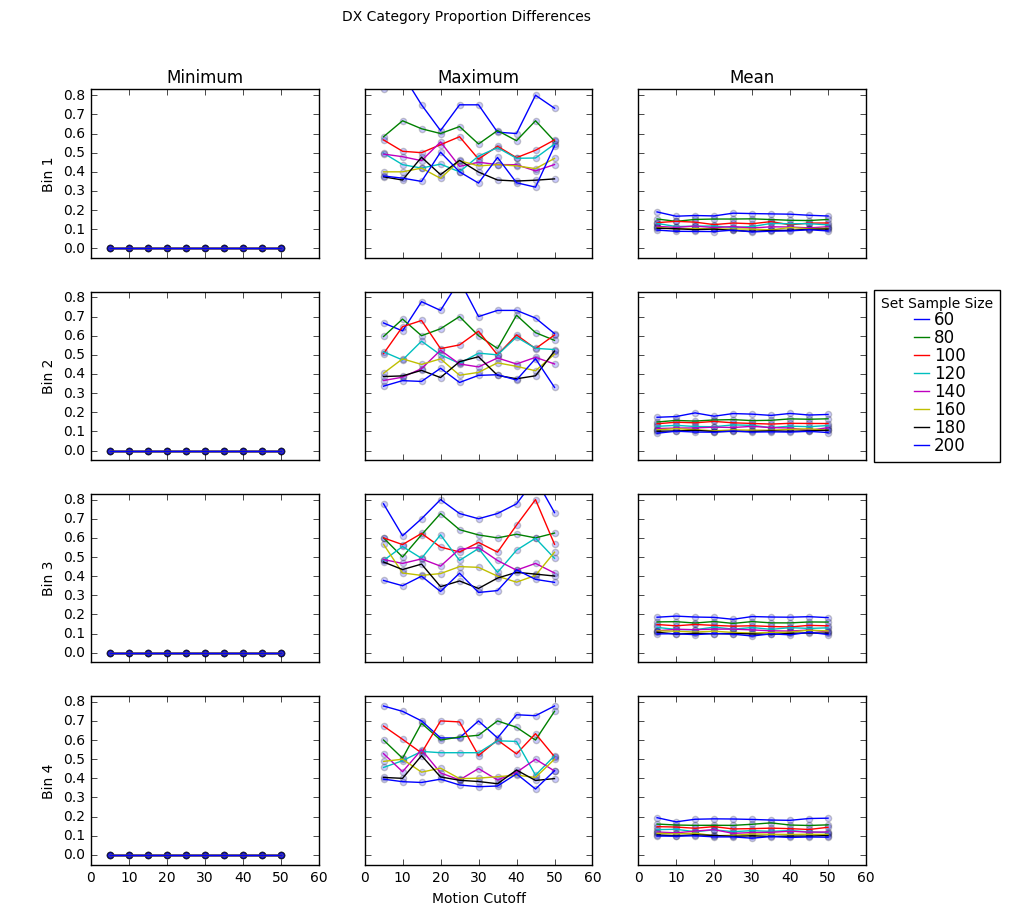

In [558]:
themotionbins = proportionDF_JAL['bin_number'].unique()
propPlotFig, propPlotAx = plt.subplots(nrows=len(themotionbins), ncols=3, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 10)

labels = []

for N_set in range(30*2, 110*2, 10*2):
    binindex = 0
    for motionbin in themotionbins:
        tmpPropDF = proportionDF_JAL.query("property == 'DX_GROUP' & N_set == " + str(N_set/2) + " & bin_number == " + str(motionbin))
        mins = tmpPropDF.query("statistic == 'min'").value
        maxs = tmpPropDF.query("statistic == 'max'").value
        means = tmpPropDF.query("statistic == 'mean'").value
        motion_threshs = tmpPropDF.query("statistic == 'max'").motion_thresh
        propPlotAx[binindex,0].scatter(motion_threshs, mins, alpha=.2)
        propPlotAx[binindex,0].plot(motion_threshs, mins)
        propPlotAx[binindex,1].scatter(motion_threshs, maxs, alpha=.2)
        propPlotAx[binindex,1].plot(motion_threshs, maxs)
        propPlotAx[binindex,2].scatter(motion_threshs, means, alpha=.2)
        propPlotAx[binindex,2].plot(motion_threshs, means)
        binindex += 1
    labels.append(N_set)

handles, labels_trash = propPlotAx[0,0].get_legend_handles_labels()
maxrow = len(themotionbins)-1
propPlotAx[0,0].set_ylim([-.05, .83])
propPlotAx[maxrow,1].set_xlabel('Motion Cutoff')
propPlotAx[0,0].set_title('Minimum')
propPlotAx[0,1].set_title('Maximum')
propPlotAx[0,2].set_title('Mean')
for binindex, motionbin in enumerate(themotionbins):
    propPlotAx[binindex,0].set_ylabel('\n\nBin ' + str(motionbin))
propPlotAx[maxrow/2,2].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)
propPlotFig.suptitle('DX Category Proportion Differences')

In [559]:
proportionDF_JAL.property.unique()

array(['DX_GROUP', 'SEX', 'AGE_YRS'], dtype=object)

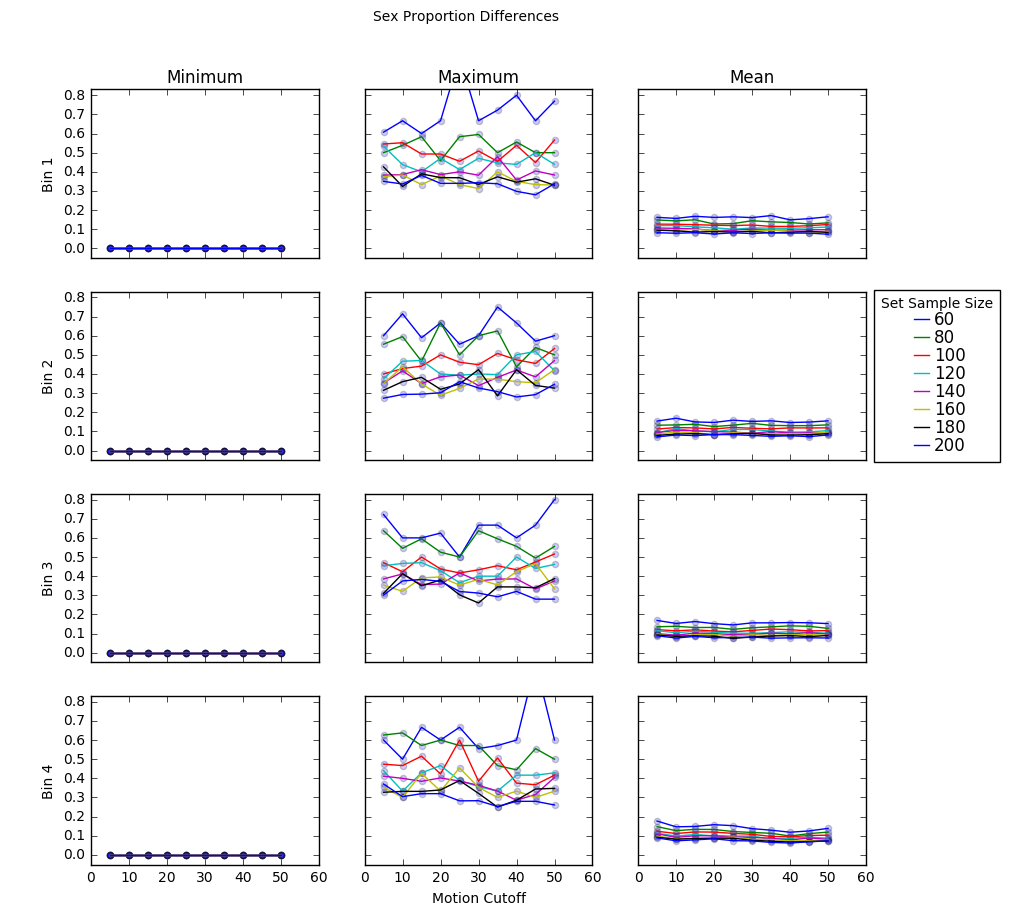

In [560]:
themotionbins = proportionDF_JAL['bin_number'].unique()
propPlotFig, propPlotAx = plt.subplots(nrows=len(themotionbins), ncols=3, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 10)

labels = []

for N_set in range(30*2, 110*2, 10*2):
    binindex = 0
    for motionbin in themotionbins:
        tmpPropDF = proportionDF_JAL.query("property == 'SEX' & N_set == " + str(N_set/2) + " & bin_number == " + str(motionbin))
        mins = tmpPropDF.query("statistic == 'min'").value
        maxs = tmpPropDF.query("statistic == 'max'").value
        means = tmpPropDF.query("statistic == 'mean'").value
        motion_threshs = tmpPropDF.query("statistic == 'max'").motion_thresh
        propPlotAx[binindex,0].scatter(motion_threshs, mins, alpha=.2)
        propPlotAx[binindex,0].plot(motion_threshs, mins)
        propPlotAx[binindex,1].scatter(motion_threshs, maxs, alpha=.2)
        propPlotAx[binindex,1].plot(motion_threshs, maxs)
        propPlotAx[binindex,2].scatter(motion_threshs, means, alpha=.2)
        propPlotAx[binindex,2].plot(motion_threshs, means)
        binindex += 1
    labels.append(N_set)

handles, labels_trash = propPlotAx[0,0].get_legend_handles_labels()
maxrow = len(themotionbins)-1
propPlotAx[0,0].set_ylim([-.05, .83])
propPlotAx[maxrow,1].set_xlabel('Motion Cutoff')
propPlotAx[0,0].set_title('Minimum')
propPlotAx[0,1].set_title('Maximum')
propPlotAx[0,2].set_title('Mean')
for binindex, motionbin in enumerate(themotionbins):
    propPlotAx[binindex,0].set_ylabel('\n\nBin ' + str(motionbin))
propPlotAx[maxrow/2,2].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)
propPlotFig.suptitle('Sex Proportion Differences')

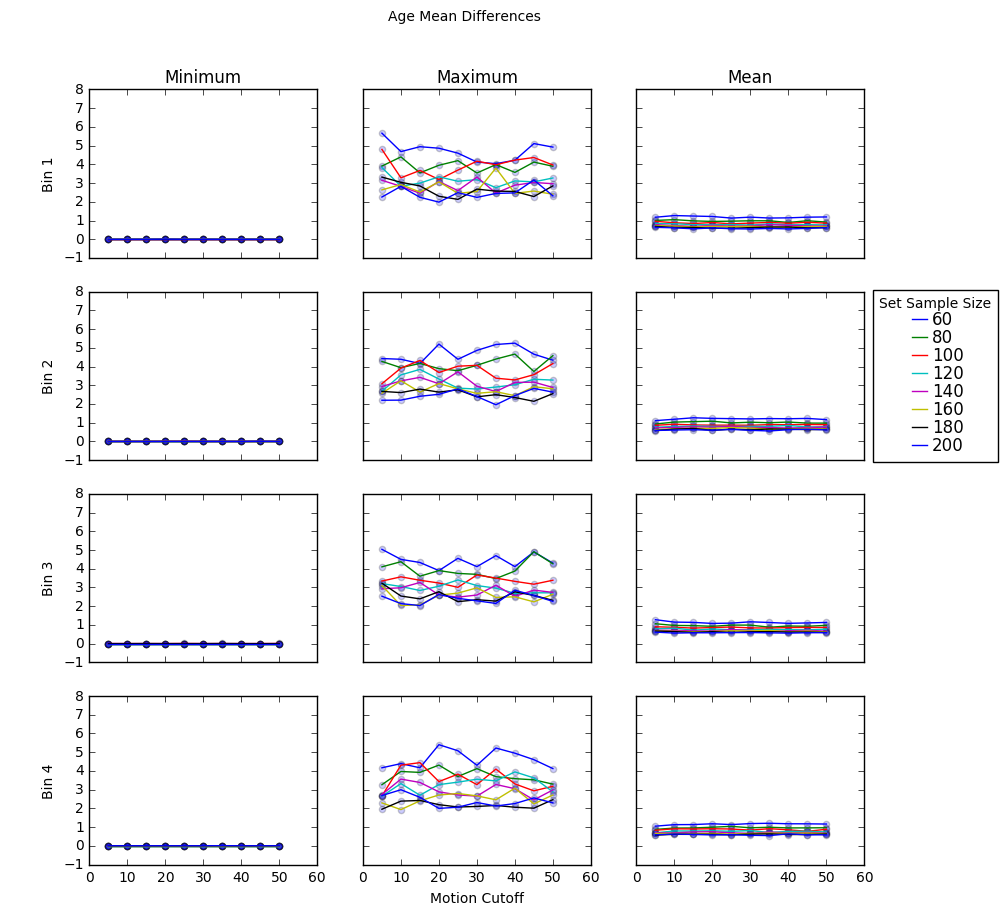

In [565]:
themotionbins = proportionDF_JAL['bin_number'].unique()
propPlotFig, propPlotAx = plt.subplots(nrows=len(themotionbins), ncols=3, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 10)

labels = []

for N_set in range(30*2, 110*2, 10*2):
    binindex = 0
    for motionbin in themotionbins:
        tmpPropDF = proportionDF_JAL.query("property == 'AGE_YRS' & N_set == " + str(N_set/2) + " & bin_number == " + str(motionbin))
        mins = tmpPropDF.query("statistic == 'min'").value
        maxs = tmpPropDF.query("statistic == 'max'").value
        means = tmpPropDF.query("statistic == 'mean'").value
        motion_threshs = tmpPropDF.query("statistic == 'max'").motion_thresh
        propPlotAx[binindex,0].scatter(motion_threshs, mins, alpha=.2)
        propPlotAx[binindex,0].plot(motion_threshs, mins)
        propPlotAx[binindex,1].scatter(motion_threshs, maxs, alpha=.2)
        propPlotAx[binindex,1].plot(motion_threshs, maxs)
        propPlotAx[binindex,2].scatter(motion_threshs, means, alpha=.2)
        propPlotAx[binindex,2].plot(motion_threshs, means)
        binindex += 1
    labels.append(N_set)

handles, labels_trash = propPlotAx[0,0].get_legend_handles_labels()
maxrow = len(themotionbins)-1
propPlotAx[0,0].set_ylim([-1, 8])
propPlotAx[maxrow,1].set_xlabel('Motion Cutoff')
propPlotAx[0,0].set_title('Minimum')
propPlotAx[0,1].set_title('Maximum')
propPlotAx[0,2].set_title('Mean')
for binindex, motionbin in enumerate(themotionbins):
    propPlotAx[binindex,0].set_ylabel('\n\nBin ' + str(motionbin))
propPlotAx[maxrow/2,2].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)
propPlotFig.suptitle('Age Mean Differences')

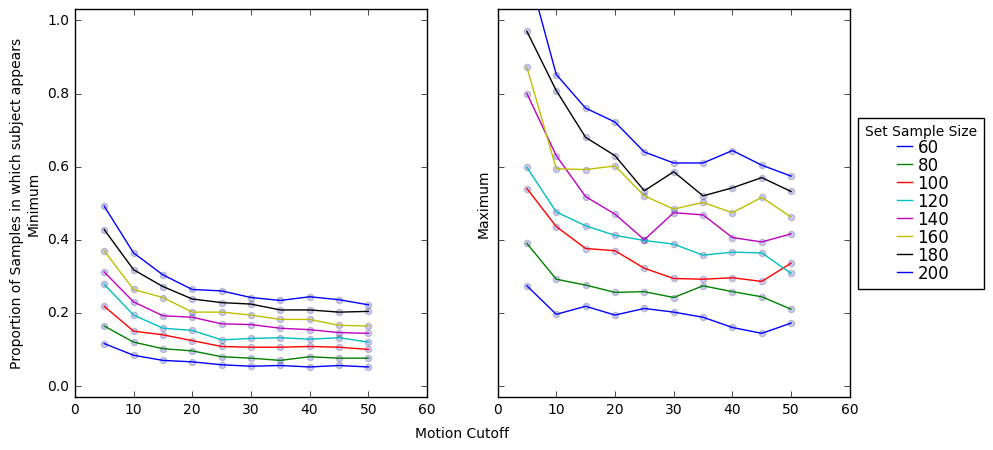

In [302]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 110*2, 10*2):
    tmpPropDF = proportionDF_JAL.query("N_set == " + str(N_set))
    propPlotAx[0].scatter(tmpPropDF.motion_thresh, tmpPropDF.prop_min, alpha=.2)
    propPlotAx[0].plot(tmpPropDF.motion_thresh, tmpPropDF.prop_min)
    propPlotAx[1].scatter(tmpPropDF.motion_thresh, tmpPropDF.prop_max, alpha=.2)
    propPlotAx[1].plot(tmpPropDF.motion_thresh, tmpPropDF.prop_max)
    labels.append(N_set)

handles, labels_trash = propPlotAx[1].get_legend_handles_labels()
propPlotAx[0].set_ylim([-.03, 1.03])
propPlotAx[0].set_xlabel('Motion Cutoff')
propPlotAx[0].xaxis.set_label_coords(1.1, -.075)
propPlotAx[0].set_ylabel('Proportion of Samples in which subject appears\nMinimum')
propPlotAx[1].set_ylabel('\nMaximum')
propPlotAx[1].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

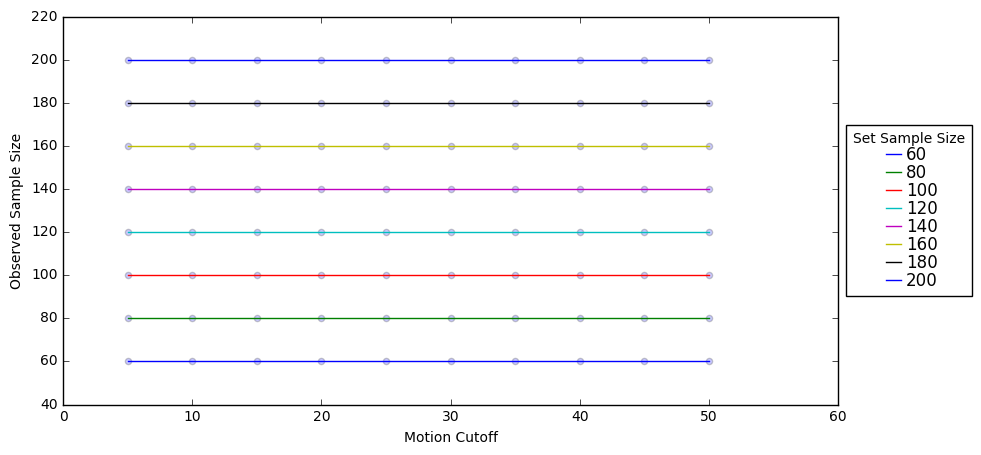

In [303]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 110*2, 10*2):
    tmpPropDF = proportionDF_JAL.query("N_set == " + str(N_set))
    propPlotAx.scatter(tmpPropDF.motion_thresh, tmpPropDF.N_obs, alpha=.2)
    propPlotAx.plot(tmpPropDF.motion_thresh, tmpPropDF.N_obs)
    labels.append(N_set)

handles, labels_trash = propPlotAx.get_legend_handles_labels()
propPlotAx.set_xlabel('Motion Cutoff')
propPlotAx.set_ylabel('Observed Sample Size')
propPlotAx.legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)